# Classification

Polarimetric radars measure both convectional information from scatterer's (reflectivity and Doppler velocity) and additional information that is derived from two orthogonally polarised pulses (Z<sub>H</sub> and Z<sub>V</sub>). This additional information can be used to infer the scatterer's shape, homeogenity and liquid water content. More specifically:

1. Z<sub>dr</sub> (Differential Reflectivity)
* ratio of Z<sub>H</sub> to Z<sub>V</sub> in dB
* scatterers with vertically aligned shapes return negative values, horitzontal shapes return positive values, purely chaotic or uniform shapes return zero. 
2. ρ<sub>hv</sub> (Co-polar Correleration Coefficient)
* correlation between Z<sub>H</sub> and Z<sub>V</sub> returns
* ρ<sub>hv</sub>→1 = increasingly homogenous
3. $\phi$<sub>dp</sub> (Differential Phase)
* phase shift between H and V polarisations.
* Raindrops are oblate when sampled horizontally, therefore the H pulse encounters more of the drops than V pulse producing a positive phase shift.

<br>

<img src="https://arrc.ou.edu/~guzhang/Polarimetry/img/intro/radarwave.png" alt="concept" width="600"/>

*Sketch of weather radar polarimetry principle. H and V denote the horizontal and vertical axes, respectively (source: https://arrc.ou.edu/~guzhang/Polarimetry/variables.htm)*

<br>

Using a combination of conventional and polarimetric information, it is possible to develop a robust classification of scatterer type. Thinking about this further, some examples are:

1. Moderate intensity rain: moderate Z<sub>H</sub>, very high ρ<sub>hv</sub>, positive Z<sub>dr</sub>, some $\phi$<sub>dp</sub>
1. Dry Hail: high Z<sub>H</sub>, moderate ρ<sub>hv</sub>, zero or negative Z<sub>dr</sub>, little or no $\phi$<sub>dp</sub>
1. Ground clutter: high Z<sub>H</sub>, noisy ρ<sub>hv</sub>, noisy Z<sub>dr</sub>, no $\phi$<sub>dp</sub>, no velocity
1. Dry Ice crystals: low to moderate Z<sub>H</sub>, high ρ<sub>hv</sub>, Z<sub>dr</sub> depends on alignment, little or no $\phi$<sub>dp</sub>,
1. Smoke: low to moderate Z<sub>H</sub>, low ρ<sub>hv</sub>, noisy Z<sub>dr</sub>, no $\phi$<sub>dp</sub>

Note that melting hail and ice crystals will change their shape and liquid water content. This also allows for the detection of the 'melting layer'.

For more information on the principles and applications of polarimetric weather radar, see Kumjian 2013 (doi: 10.15191/nwajom.2013.0119)

<br>

<img src="images/cp2-rhi.png" alt="CP-2 RHI" width="800"/>

## Let's begin.

Today we'll do two exercises: First looking at developing our own simple logic-based classifier. Then we'll look at an widely used classifer and discuss potential improvement using machine learning.

## Exercise 1: Logic-based classifier

First, we can use python to download an OPOL volume

[Link](https://dapds00.nci.org.au/thredds/catalog/hj10/opol/level_1b/v2020/ppi/in2019_t03/20191225/catalog.html?dataset=hj10/in2019_t03/20191225/9776HUB-PPIVol-20191225-123000-0000.cfradial.nc) to original data source accessed through openradar.io

In [3]:
import urllib.request
opol_vol_url= 'https://dapds00.nci.org.au/thredds/fileServer/hj10/opol/level_1b/v2020/ppi/in2019_t03/20191225/9776HUB-PPIVol-20191225-123000-0000.cfradial.nc'
opol_vol_local_ffn = 'data/9776HUB-PPIVol-20191225-123000-0000.cfradial.nc'
urllib.request.urlretrieve(opol_vol_url, opol_vol_local_ffn)

('data/9776HUB-PPIVol-20191225-123000-0000.cfradial.nc',
 <http.client.HTTPMessage at 0x7f8d67801d80>)

### We're going to experiment with using reflectivty (~scatterer intensity) and differential reflectivity (shape)

In [4]:
import pyart
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np

# read our OPOL volume and extract the reflectivity and differential reflectivity fields
radar = pyart.io.read(opol_vol_local_ffn)
reflectivity = radar.fields['total_power']['data']
diff_reflectivity = radar.fields['differential_reflectivity']['data']

#build a colormap for our simple classifier
color_list = [
    "White", #None
    "MediumBlue", 
    "MediumPurple",
    "Green",
    "Red",
    ]
cmap = colors.ListedColormap(color_list)

### As a first step let's create a simple (and very imperfect) classifier using reflectivity to distingush between heavy precipitation (small hail/rain) and everything else

[Text(1, 0, 'None'),
 Text(1, 1, 'rain/small hail/grapuel'),
 Text(1, 2, 'everything else')]

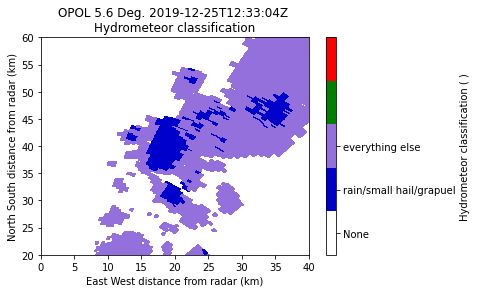

In [13]:
simple_classifier = np.zeros_like(reflectivity)

#some simple log rules based on what we discussed
simple_classifier[reflectivity >= 30] = 1 #small hail/rain
simple_classifier[reflectivity < 30] = 2 #everything else

#add back into radar object and plot
radar.add_field_like('radar_echo_classification', 'simple_classification', simple_classifier, replace_existing=True)

fig, ax = plt.subplots()
gr = pyart.graph.RadarDisplay(radar)
gr.plot_ppi('simple_classification', sweep=6, vmin=-0.5, vmax=4.5, cmap=cmap)
ax.set_xlim(0, 40)
ax.set_ylim(20, 60)

gr.cbs[-1].set_ticks([0, 1, 2])
gr.cbs[-1].ax.set_yticklabels(["None", "rain/small hail/grapuel", "everything else"])

### Now let's use differential reflectivity to separate rain from small hail

[Text(1, 0, 'None'),
 Text(1, 1, 'rain'),
 Text(1, 2, 'small hail'),
 Text(1, 3, 'everything else')]

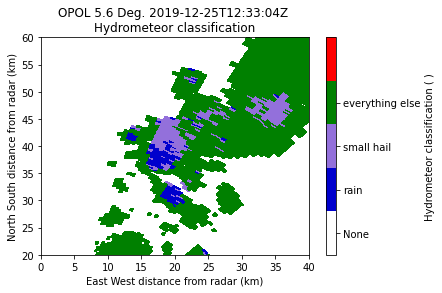

In [12]:
better_classifier = np.zeros_like(reflectivity)

better_classifier[np.logical_and(reflectivity >= 30, diff_reflectivity > 0.5)] = 1 #rain
better_classifier[np.logical_and(reflectivity >= 30, diff_reflectivity <= 0.5)] = 2 #small hail
better_classifier[reflectivity < 30] = 3 #everything else

radar.add_field_like('radar_echo_classification', 'better_classification', better_classifier, replace_existing=True)

fig, ax = plt.subplots()
gr = pyart.graph.RadarDisplay(radar)
gr.plot_ppi('better_classification', sweep=6, vmin=-0.5, vmax=4.5, cmap=cmap)
ax.set_xlim(0, 40)
ax.set_ylim(20, 60)

gr.cbs[-1].set_ticks([0, 1, 2, 3])
gr.cbs[-1].ax.set_yticklabels(["None", "rain", "small hail/grapuel", "everything else"])

### We can take one step further and separate snow/light rain

[Text(1, 0, 'None'),
 Text(1, 1, 'rain'),
 Text(1, 2, 'small hail/grapuel'),
 Text(1, 3, 'snow/light rain'),
 Text(1, 4, 'everything else')]

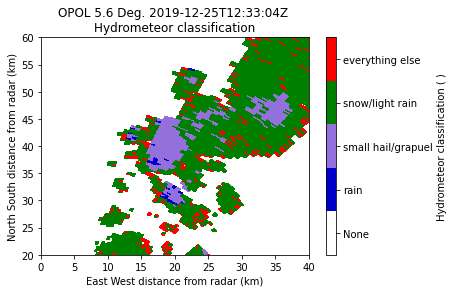

In [15]:
best_classifier = np.zeros_like(reflectivity)

best_classifier[np.logical_and(reflectivity >= 30, diff_reflectivity > 1)] = 1 #rain
best_classifier[np.logical_and(reflectivity >= 30, diff_reflectivity <= 1)] = 2 #small hail
best_classifier[np.logical_and(reflectivity < 30, diff_reflectivity <= 1)] = 3 #snow or light rain
best_classifier[np.logical_and(reflectivity < 30, diff_reflectivity > 1)] = 4 #everything else

radar.add_field_like('radar_echo_classification', 'best_classification', best_classifier, replace_existing=True)

fig, ax = plt.subplots()
gr = pyart.graph.RadarDisplay(radar)
gr.plot_ppi('best_classification', sweep=6, vmin=-0.5, vmax=4.5, cmap=cmap)
ax.set_xlim(0, 40)
ax.set_ylim(20, 60)

gr.cbs[-1].set_ticks([0, 1, 2, 3, 4])
gr.cbs[-1].ax.set_yticklabels(["None", "rain", "small hail/grapuel", "snow/light rain", "everything else"])

Looks like our classifier could be improved further by looking at the differential reflectivity threshold used for snow/light rain!

### Task: Separate non meteorological from meteorological!

In this task you'll be looking at a different area from the same radar volume that contains some non meteorological and meteorological returns. Non meteorotolical includes terrain and clear air.

Thinking about this some more...

1) Terrain generally has a high Z and a low ρ<sub>hv</sub>.

1) Clear air generally has a low Z and a low ρ<sub>hv</sub>.

1) Meteorological echoes generally have a very high ρ<sub>hv</sub>.

Let's now take a look at these fields

(-50.0, 50.0)

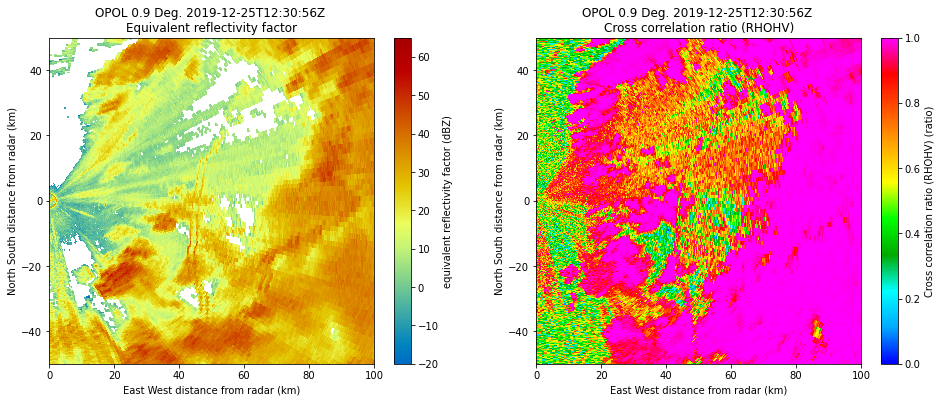

In [75]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
gr = pyart.graph.RadarDisplay(radar)
gr.plot_ppi('total_power', sweep=0, vmin=-20, vmax=65, ax=axs[0])
axs[0].set_xlim(0, 100)
axs[0].set_ylim(-50, 50)
gr.plot_ppi('cross_correlation_ratio', sweep=0, vmin=0, vmax=1, ax=axs[1])
axs[1].set_xlim(0, 100)
axs[1].set_ylim(-50, 50)

Now you can develop your own filter! Insert values for A and B into the logical filters.

In [ ]:
A = ???? #reflectivity threshold
B = ???? #cross correlation threshold

reflectivity = radar.fields['total_power']['data']
cross_correlation = radar.fields['cross_correlation_ratio']['data']
my_classifier = np.zeros_like(reflectivity)

my_classifier[np.logical_and(reflectivity < A, cross_correlation < B)] = 1 #clear air
my_classifier[np.logical_and(reflectivity >= A, cross_correlation < B)] = 2 #terrain
my_classifier[cross_correlation >= B] = 3 #meteorological

radar.add_field_like('radar_echo_classification', 'my_classifier', my_classifier, replace_existing=True)

fig, ax = plt.subplots()
gr = pyart.graph.RadarDisplay(radar)
gr.plot_ppi('my_classifier', sweep=0, vmin=-0.5, vmax=4.5, cmap=cmap)
ax.set_xlim(0, 100)
ax.set_ylim(-50, 50)
gr.cbs[-1].set_ticks([0, 1, 2, 3])
gr.cbs[-1].ax.set_yticklabels(["None", "clear air", "terrain", "meteorological"])


## Exercise 2: Exploring the CSU Hydrometeor Classification

In this exercise you'll look at the fuzzy logic-based classifier developed by Colorado State University. See Thompson et al. (2014) doi:10.1175/JTECH-D-13-00119.1

This classification is included as part of the level 1b files for all radar types/sites

First we'll plot up the classification for some examples

In [77]:
def adjust_csuhca_scheme_colorbar_for_pyart(cb):
    """
    Generate colorbar for the hydrometeor classification.
    """
    cb.set_ticks(np.linspace(0.5, 10.5, 11))
    cb.ax.set_yticklabels(
        [
            "None",
            "Driz",
            "Rain",
            "IceCry",
            "IceAgg",
            "W Snow",
            "V Ice",
            "LD Gpl",
            "HD Gpl",
            "Hail",
            "Big Dp",
        ]
    )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb

def csu_color_map():

    color_list = [
        "White", #None
        "LightBlue", #Driz
        "SteelBlue", #Rain
        "MediumBlue", #IceCry
        "Plum", #IceAgg
        "MediumPurple", #W Snow
        "m", #V Ice
        "Green", #LD Gpl
        "YellowGreen", #HD Gpl
        "Gold", #Hail
        "Red", #Big Dp
        ]
    
    return colors.ListedColormap(color_list)

def _plot_ppi(graph_obj, field_name, ax, vmin, vmax, cmap, sweep, ring_list):
    """
    generated ppi plot for a given field using the graph object
    
    Parameters:
    ===========
        graph_obj: Py-ART graph object
        field_name: string
            field name
        ax: axis handle
        vmin: float
            min value for colormap in units of field
        vmax: float
            max value for colormap in units of field
        cmap: cmap name string from matplotlib or pyart
        sweep: int
            sweep index to plot
        ring_list: list of ints
            list of radius in km to plot range rings
            
    Returns:
    ========
        None
    
    """
    #create ppi plot
    graph_obj.plot_ppi(field_name, sweep=sweep, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(graph_obj.generate_title(field_name, sweep=sweep, datetime_format='%Y-%m-%dT%H:%M'))
    #annotate
    graph_obj.plot_range_rings(ring_list, ax=ax)
    ax.set_aspect(1)
    ax.set_xlim(0, 40)
    ax.set_ylim(20, 60)

Plot using the same sweep (6) as our basic classifiers

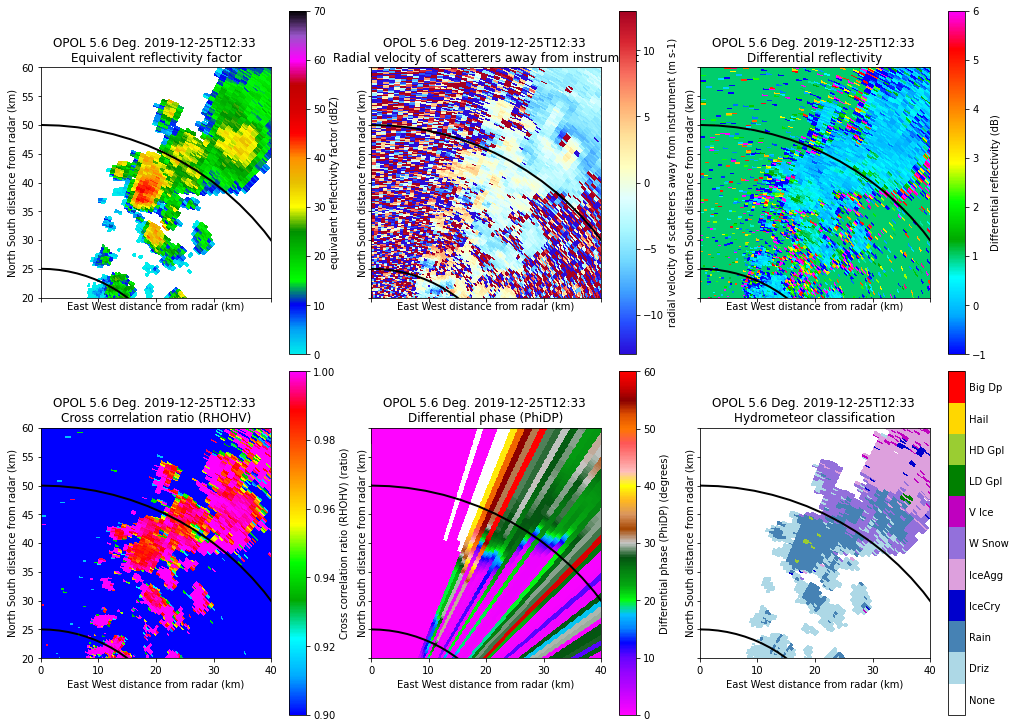

In [84]:
gr = pyart.graph.RadarDisplay(radar)
fig, the_ax = plt.subplots(2, 3, figsize=(14, 10), sharex=True, sharey=True, constrained_layout=True)
the_ax = the_ax.flatten()

sweep = 6
gatefilter = pyart.correct.GateFilter(radar)
ring_list = [25,50]

# corrected and calibrated reflectivity
_plot_ppi(gr, 'total_power', the_ax[0], vmin=0, vmax=70,
          cmap='pyart_NWSRef', sweep=sweep, ring_list=ring_list)
# Doppler velocity
_plot_ppi(gr, 'velocity', the_ax[1], vmin=-13, vmax=13,
          cmap='pyart_BuDRd12', sweep=sweep, ring_list=ring_list)
#differential reflectivity
_plot_ppi(gr, 'differential_reflectivity', the_ax[2], vmin=-1, vmax=6,
          cmap='pyart_RefDiff',sweep=sweep, ring_list=ring_list)
#cross_correlation_ratio
_plot_ppi(gr, 'cross_correlation_ratio', the_ax[3], vmin=0.9, vmax=1,
            cmap='pyart_RefDiff', sweep=sweep, ring_list=ring_list)  
#corrected_differential_phase
_plot_ppi(gr, 'corrected_differential_phase', the_ax[4], vmin=0, vmax=60,
          cmap='pyart_Wild25', sweep=sweep, ring_list=ring_list)    
# Classification        
csuhca_cmap = csu_color_map()
_plot_ppi(gr, 'radar_echo_classification', the_ax[5], vmin=0, vmax=11,
                          cmap=csuhca_cmap, sweep=sweep, ring_list=ring_list)
gr.cbs[-1] = adjust_csuhca_scheme_colorbar_for_pyart(gr.cbs[-1])

Let's now look at the lowest sweep

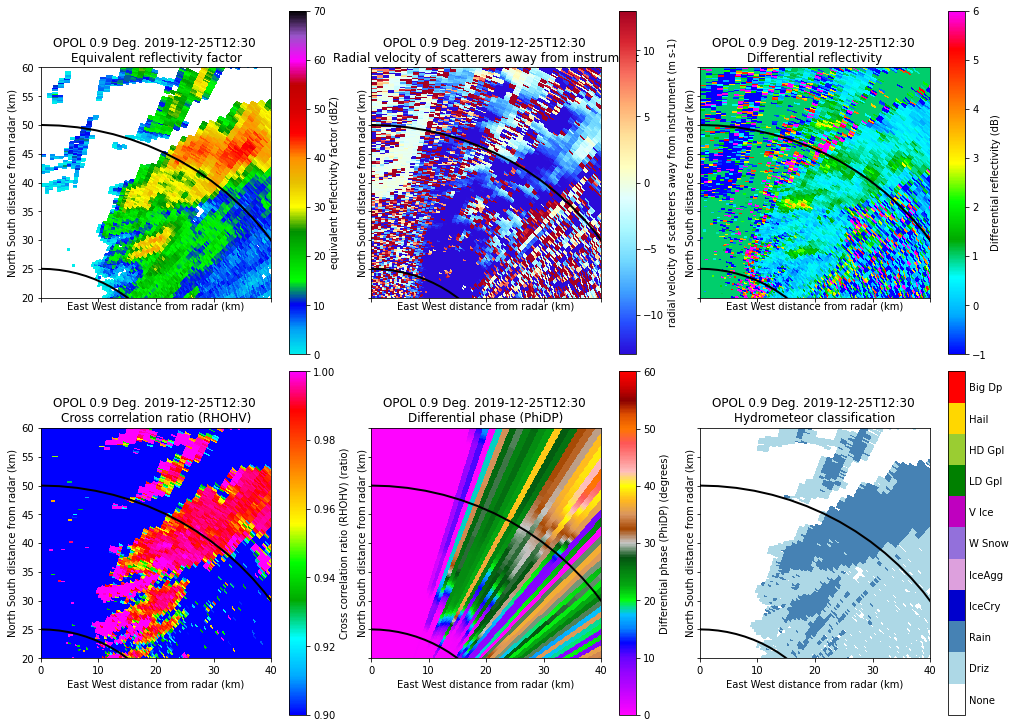

In [85]:
gr = pyart.graph.RadarDisplay(radar)
fig, the_ax = plt.subplots(2, 3, figsize=(14, 10), sharex=True, sharey=True, constrained_layout=True)
the_ax = the_ax.flatten()

plt_range = 75 #km
sweep = 0
gatefilter = pyart.correct.GateFilter(radar)

# corrected and calibrated reflectivity
_plot_ppi(gr, 'total_power', the_ax[0], vmin=0, vmax=70,
          cmap='pyart_NWSRef', sweep=sweep, ring_list=ring_list)
# Doppler velocity
_plot_ppi(gr, 'velocity', the_ax[1], vmin=-13, vmax=13,
          cmap='pyart_BuDRd12', sweep=sweep, ring_list=ring_list)
# differential reflectivity
_plot_ppi(gr, 'differential_reflectivity', the_ax[2], vmin=-1, vmax=6,
          cmap='pyart_RefDiff',sweep=sweep, ring_list=ring_list)
# cross_correlation_ratio
_plot_ppi(gr, 'cross_correlation_ratio', the_ax[3], vmin=0.9, vmax=1,
            cmap='pyart_RefDiff', sweep=sweep, ring_list=ring_list)  
# corrected_differential_phase
_plot_ppi(gr, 'corrected_differential_phase', the_ax[4], vmin=0, vmax=60,
          cmap='pyart_Wild25', sweep=sweep, ring_list=ring_list)    
# Classification        
csuhca_cmap = csu_color_map()
_plot_ppi(gr, 'radar_echo_classification', the_ax[5], vmin=0, vmax=11,
                          cmap=csuhca_cmap, sweep=sweep, ring_list=ring_list)
gr.cbs[-1] = adjust_csuhca_scheme_colorbar_for_pyart(gr.cbs[-1])

Task: Let's dig into this classifier a bit to see what's driving the different ice crystal types!

We can do this by extracting field that relate to ice crystals (Z, zdr, rhohv) and see how the classifier separates the phase space

[todo]

## Final Discussion

Classification algorthims

A majority of classification algorthims are built on fuzzy logic principles and often include additional information from numerical models (e.g., temperature) and derived fields (e.g., $\phi$<sub>dp</sub> texture). Fuzzy logic is essentially a series of logic-based rules (similar to the first exercise) that are combined to generate a confidence value for each class type. The most confident type is then assigned to that pixel.

Machine learning offers a potential avenue to improve upon the skill of fuzzy logic approaches. In particular, unsupervised clustering allows the machine to determine the optical set of probability functions for determining a class, which then can be later labelled by an experienced user who understand what the radar observed properties represent. One example of this is the Gaussian Mixture Model.